In [13]:
%matplotlib inline
import glob
import pandas
import json
import datetime

In [15]:
datetime.datetime.utcnow().isoformat()

'2016-03-09T19:28:09.887749'

In [5]:
# Abuse /tmp as a cache so we don't do so many GETs
!mkdir -p /tmp/report-data
!aws s3 sync s3://ghcperf-results /tmp/report-data --no-sign-request --quiet
!find /tmp/report-data | wc

     22      22    2298


In [3]:
def parse_name(s):
    # Takes 
    # /tmp/report-data/5a494d8ec688e42601262913172f24cee7a36c9b/perf-1yjvliagav9mf7klzl4qjqs95iggv343-scientific-0.3.4.4.csv
    # returns
    # 5a494d8..., scientific-0.3.4.4
    parts = s.split('/')
    name = parts[4].split('-', 3)[2]
    sha = parts[3]
    return sha, name
def read(x):
    df = pandas.read_csv(x, skiprows=2, header=None, names=["value", "?", "name", "long_value", "?2"])
    sha, package = parse_name(x)
    df['sha'] = sha[:8]
    df['package'] = package
    with open('/tmp/report-data/' + sha + "/" + "commit_meta.json") as f:
        commit = json.load(f)
        df['timestamp'] = commit['committer']['date'] 
    return df

In [4]:
df = pandas.concat([read(x) for x in glob.glob('/tmp/report-data/*/*csv')], axis=0)
df.head()

,value,?,name,long_value,?2,sha,package,timestamp
0,20965.327651,NaN,task-clock,20965327651,100,5a494d8e,scientific,2016-03-09T13:16:13Z
1,20847,NaN,context-switches,20965327651,100,5a494d8e,scientific,2016-03-09T13:16:13Z
2,11568,NaN,cpu-migrations,20965327651,100,5a494d8e,scientific,2016-03-09T13:16:13Z
3,1420941,NaN,page-faults,20965327651,100,5a494d8e,scientific,2016-03-09T13:16:13Z
4,<not supported>,NaN,cycles,0,100,5a494d8e,scientific,2016-03-09T13:16:13Z


In [5]:
df = df[(df.name == "task-clock")]
df['value'] = df['value'].astype('float')
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

/nix/store/5d2qd7ax9ww1jc5iavg9s36j56z765a4-python2.7-matplotlib-1.5.1/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736032.552928, right=736032.552928
  'left=%s, right=%s') % (left, right))


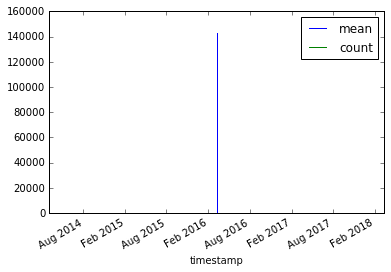

In [12]:
df.groupby(['timestamp', 'package'])['value'].agg(['mean', 'count']).reset_index('package').plot()

In [34]:
df[df.package.isin(['aeson', 'text'])]\
    .groupby(['timestamp', 'sha', 'package'])\
    .value\
    .agg(['mean', 'median', 'std'])\

mean         median         std
timestamp           sha      package                                          
2016-03-09 13:16:13 5a494d8e aeson    124098.443875  124041.674617  170.106011
                             text     112309.488031  112286.952585   82.997220